<p>
    We begin by importing the necessary python libraries to approach the problem:
</p>

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import eigsh

<h1>2D Circle (Coordinate Transform Method) - Eigenvalue Problem in Polar Co-ordinates</h1>
<p>After eliminating the Time Dependence from the 2D Wave Equation using separation of variables, we arrive at the Helmholtz Equation.
<br><br>
We wish to solve this as an eigenvalue problem of the following form for the set of eigenmodes on a polar (r,$\theta$) plane:</p>
<p>$$\nabla^2z(r,\theta) = -s^2z(r,\theta)$$</p>

<p>Let us first note the the form of the Laplacian in polar coordinates: </p><br>
$$\nabla^2 = \frac{\partial^2}{\partial r^2} + \frac{1}{r}\frac{\partial}{\partial r} + \frac{1}{r^2}\frac{\partial}{\partial \theta^2}$$

<p>
The presence of $$\frac{1}{r},\frac{1}{r^2}$$<br>
is somewhat problematic as we will have terms approaching infinity in the centre where the radial distance is very small.
</p>
<p>
To avoid this, we employ a change of variable to the system - changing from 'r' to a new parameter 'u' where:
</p><br>
$$u = \frac{1}{r}$$
<p>
This yields a new form of our operator in terms of u instead of r:
</p><br>
$$\nabla^2 = u^4\frac{\partial^2}{\partial u^2} + u^3\frac{\partial}{\partial u} + u^2\frac{\partial}{\partial \theta^2}$$<br>
<p>
The CDA (Central Difference Approximation) was then used to discretise the derivative terms in the Laplacian.
<br><br>
$$\frac{\partial^2 z(u_i,\theta_j)}{\partial u^2} = \frac{z(u_{i+1},\theta_j)-2z(u_i,\theta_j)+z(u_{i-1},\theta_j)}{(\Delta{u})^2}$$
    <br>
$$\frac{\partial^2 z(u_i,\theta_j)}{\partial \theta^2} = \frac{z(u_{i},\theta_{j+1})-2z(u_i,\theta_j)+z(u_{i},\theta_{j-1})}{(\Delta{\theta})^2}$$
    <br>
$$\frac{\partial z(u_i,\theta_j)}{\partial u} = \frac{z(u_{i+1},\theta_{j})-z(u_{i-1},\theta_{j})}{2\Delta{u}}$$
<br><br>
Neumann boundary conditions were imposed on the system.<br><br>
It is to be noted that we chose the innermost point to be a value arbitrarily close to zero instead of zero (again to avoid infinites).    
At the spatial boundaries ie. innermost point of circle and edge of the circle (r=Nr and r=0.001 or u=Nu and u=1/0.001 for all $\theta$)...
</p>
<br><br>
$$\frac{\partial z(u_i,\theta_j)}{\partial r} = 0$$
<br>
A backward difference scheme was applied to the outer boundary and a forward difference scheme was applied to the inner boundary:
</p>
<br>
$$\frac{z(u_{i},\theta_{j})-z(u_{i-1},\theta_{j})}{\Delta{u}} = 0$$
    
$$\frac{z(u_{i+1},\theta_{j})-z(u_{i},\theta_{j})}{\Delta{u}} = 0$$
<br>
<p>

A Tridiagonal Matrix was constructed from the boundary/interior approximations. 

</p>
We obtain the following formulae to use in our triadiagonal matrix:
    
For the Interior points -
</p>
<p>
$$z(u_i,\theta_j): -2\frac{u^4}{(\Delta{u})^2} -2\frac{u^2}{(\Delta{\theta})^2}$$
<br>
$$z(u_{i+1},\theta_j): \frac{u^4}{(\Delta{u})^2} + \frac{u^3}{2\Delta u}$$
<br>
$$z(u_{i-1},\theta_j): \frac{u^4}{(\Delta{u})^2} - \frac{u^3}{2\Delta u}$$
<br>
$$z(u_{i},\theta_{j+1}): \frac{u^2}{(\Delta{\theta})^2}$$
<br>
$$z(u_{i},\theta_{j-1}): \frac{u^2}{(\Delta{\theta})^2}$$
</p>
<br>
<p>
And for the boundary conditions -
</p>
<p>
$$z(u_{i},\theta_{j}) = z(u_{i-1},\theta_{j})$$
<br>
$$z(u_{i},\theta_{j}) = z(u_{i+1},\theta_{j})$$
</p>
<br><br>
<p>
We solve the tridiagonal matrix for its eigenvectors/eigenvalues and display the first 6 modes graphically.
</p>
<br><br><br>

In [172]:
# Code to solve 2D Polar Helmholtz Equation

# Simple function for accessing eigenstates of system

def reshape(eigenstate):
    return np.reshape(z[:,eigenstate], (Nu,Ntheta))

# Inputs
Nr = 100 # r grid points
Ntheta = 100 # Theta grid points
N = Nr * Ntheta # 2500 grid points per row / column
Lr = 200 # Domain size
Ltheta = math.pi * 2 # Theta ranges from 0 to 2pi

# Grid 
# Range from 0 to L with N grid points

r = np.linspace(0.1,Lr,Nr) # Mesh
theta = np.linspace(0,Ltheta, Ntheta)
dr = r[1] - r[0] # Mesh Size
dtheta = theta[1] - theta[0]

u = 1/r
du = 1/dr

Lu = Lr
Nu = Nr

# Initialise matrices

M = np.zeros((N,N)) # N rows, N columns
M.astype(float)

# Interior points
for i in range(0, Nu): # Loop over x direction skipping 1st and last grid points
    for j in range(0, Ntheta): # Loop over y direction skipping 1st and last grid points
        n=i+(j-1)*Nu # Convert ij grid point to nth grid point (n refers to the nth entry of the column vector in which the matrix acts upon)
        M[n,n]= (((-2*u[i]**4)/((du)**2)) + ((-2*u[i]**2)/((dtheta)**2))) # Main diagonal
        M[n,n-1]= (((u[i]**4)/((du)**2)) - ((u[i]**3)/(2*du))) # Off diagonal to the left 
        M[n,n+1]= (((u[i]**4)/((du)**2)) + ((u[i]**3)/(2*du))) # Off diagonal to the right
        M[n,n-Nu]= ((u[i]**2)/((dtheta)**2)) # Far off diagonal to the left
        M[n,n+Nu]= ((u[i]**2)/((dtheta)**2)) # Far off diagonal to the left
        
# Outer BC
i=Nu
for j in range(0,Ntheta):
    n=i+(j-1)*Nu # nth row for this ij
    M[n,n] = M[n,n-1]
    
# Inner BC
i=0
for j in range(0,Ntheta):
    n=i+(j-1)*Nu # nth row for this ij
    M[n,n] = M[n,n+1]


    
alpha,z = eigsh(M)

# z = np.real(z)
alpha = np.real(alpha)

z_0 = reshape(0)
z_1 = reshape(1)
z_2 = reshape(2)
z_3 = reshape(3)
z_4 = reshape(4)
z_5 = reshape(5)

print('E-value:', alpha)

E-value: [90576.38948341 91041.92273931 91043.90114067 91335.46803552
 91339.5719602  91437.46043287]


In [173]:
# Cast r and theta values to cartesians for plotting

U, Theta = np.meshgrid(u, theta)
x, y = (U)*np.cos(Theta), (U)*np.sin(Theta)

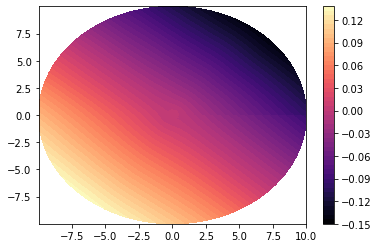

In [193]:
# Plot result

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# # ax.plot_surface(x, y, z_0, cmap='summer', linewidth=0, antialiased=False)
# # ax.plot_surface(x, y, z_1, cmap='summer', linewidth=0, antialiased=False)
# # ax.plot_surface(x, y, z_2, cmap='summer', linewidth=0, antialiased=False)
# # ax.plot_surface(x, y, z_3, cmap='summer', linewidth=0, antialiased=False)
# # ax.plot_surface(x, y, z_4, cmap='summer', linewidth=0, antialiased=False)
# # ax.plot_surface(x, y, z_5, cmap='summer', linewidth=0, antialiased=False)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# # ax.set_zlim3d((-0.075, 0.075))
# # ax.set_zlim3d((-0.07, 0.07))
# ax.view_init(18, 42)
# ax.set_title('Circular Polar 2-D Helmholtz')

ax = plt.contourf(x, y, z_4, 50, cmap='magma')
cb = plt.colorbar(ax)